# Chatbot with Profile Schema

https://github.com/langchain-ai/langchain-academy/blob/main/module-5/memoryschema_profile.ipynb

In [1]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """ユーザプロフィールスキーマ"""
    user_name: str
    interests: List[str]

In [7]:
user_profile: UserProfile = {
    "user_name": "森さん",
    "interests": ["AI", "PCゲーム", "読書"]
}
user_profile

{'user_name': '森さん', 'interests': ['AI', 'PCゲーム', '読書']}

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

user_id = "1"
namespace_for_memory = (user_id, "memory")

key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

In [ ]:
in_memory_store.search(namespace_for_memory)[0].dict()

{'value': {'user_name': '森さん', 'interests': ['AI', 'PCゲーム', '読書']},
 'key': 'user_profile',
 'namespace': ['1', 'memory'],
 'created_at': '2024-11-19T02:37:18.123671+00:00',
 'updated_at': '2024-11-19T02:37:18.123673+00:00'}

In [10]:
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': '森さん', 'interests': ['AI', 'PCゲーム', '読書']}

## プロファイルスキーマを用いたチャットボット

In [11]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

In [13]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model_with_structure = model.with_structured_output(UserProfile)

structured_output = model_with_structure.invoke([HumanMessage("こんにちは。私の名前は森です。PCゲームが好きです。")])
structured_output

{'user_name': '森', 'interests': ['PCゲーム']}

In [17]:

from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

In [18]:
MODEL_SYSTEM_MESSAGE = """あなたは記憶を持つ役立つアシスタントであり、ユーザーに関する情報を提供します。
このユーザーに関する記憶がある場合、それを使用して回答をパーソナライズしてください。
以下は記憶です（空の場合もあります）: {memory}"""

CREATE_MEMORY_INSTRUCTION = """ユーザーのチャット履歴に基づいて、ユーザープロファイルの記憶を作成または更新してください。
これを長期記憶として保存します。既存の記憶がある場合は、それを更新してください。
以下は既存の記憶です（空の場合もあります）: {memory}"""

In [25]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """長期記憶をロードし、パーソナライズされた応答を生成する"""
    user_id = config["configurable"]["user_id"]

    # 長期記憶のロード
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """チャット履歴を振り返り、長期記憶に保存する"""
    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)] + state["messages"])

    key = "user_memory"

    store.put(namespace, key, new_memory)

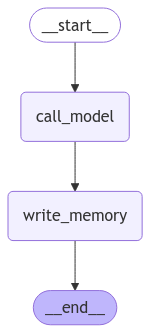

In [26]:
from joblib import Memory


builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# スレッド（セッション）を超えて記憶する長期記憶
across_thread_memory = InMemoryStore()

# スレッド内のやり取りを記憶する短期記憶
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="やあ、私の名前は森です。PCゲームと読書が好きです。よろしくお願いします。")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

やあ、私の名前は森です。PCゲームと読書が好きです。よろしくお願いします。
================================== Ai Message ==================================

やあ、森さん！お会いできて嬉しいです。PCゲームと読書が好きなんですね。最近プレイしたゲームや読んだ本で特に印象に残ったものはありますか？


In [29]:
# 長期記憶を調べる
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': '森', 'interests': ['PCゲーム', '読書']}

## より複雑なスキーマを扱う場合

In [30]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [31]:
from pydantic import ValidationError

model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

In [32]:
conversation = """オペレーター: 電報のご用件は何でしょうか？
お客様: 私たちの「信頼落下」の訓練についてメッセージを送りたいのですが。
オペレーター: かしこまりました。モールス信号で送りますか、それとも標準的な形式で？
お客様: モールスでお願いします。直鍵を使うのが大好きなんです。
オペレーター: 素晴らしいですね。メッセージの内容をどうぞ。
お客様: 「もっと高い落下に挑戦する準備ができた。それと、キャッチにはダイヤモンド隊形がいい」と伝えてください。
オペレーター: 了解しました。この大胆なメッセージには「デアデビル紙」を使いますか？
お客様: 完璧です！最速の伝書鳩で送ってください。
オペレーター: 1時間以内に到着するでしょう。"""

In [35]:
try:
    response = model_with_structure.invoke(f"""以下の会話から好みを抽出してください:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

In [37]:
print(response)

pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='モールス信号', sentence_preference_revealed='モールスでお願いします。'), OutputFormat(preference='デアデビル紙', sentence_preference_revealed='この大胆なメッセージには「デアデビル紙」を使いますか？')], favorite_telegram_operators=[OutputFormat(preference='直鍵', sentence_preference_revealed='直鍵を使うのが大好きなんです。')], preferred_telegram_paper=None), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='直鍵', sentence_preference_revealed='直鍵を使うのが大好きなんです。')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='高い', sentence_preference_revealed='もっと高い落下に挑戦する準備ができた。')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='ダイヤモンド隊形', sentence_preference_revealed='キャッチにはダイヤモンド隊形がいい')]))


## プロファイルの作成と更新にtructcallを使う

In [38]:
conversation = [HumanMessage(content="やあ、私は森です。",),
                AIMessage(content="はじめまして、森さん。"),
                HumanMessage(content="私は本当にPCゲームにはまっています。")]

In [39]:
from trustcall import create_extractor

class UserProfile(BaseModel):
    user_name: str = Field(description="ユーザ名")
    interests: List[str] = Field(description="ユーザの興味のリスト")

In [41]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)
trustcall_extractor

RunnableLambda(coerce_inputs)
| <langgraph.graph.state.CompiledStateGraph object at 0x7fa71d0ccad0>
| RunnableLambda(filter_state)

In [43]:
system_msg = "以下の会話からユーザプロフィールを抽出してください。"

result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + conversation})
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hz6i2C2iez5egNA1bOUv1SR0', 'function': {'arguments': '{"user_name":"森","interests":["PCゲーム"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 125, 'total_tokens': 138, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-25480e07-bfea-4b6a-8b88-e882a2d8072f-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': '森', 'interests': ['PCゲーム']}, 'id': 'call_hz6i2C2iez5egNA1bOUv1SR0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 125, 'output_tokens': 13, 'total_tokens': 138, 'input_token_details': {'audio': 0, 'cache_read

In [45]:
result["messages"]

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hz6i2C2iez5egNA1bOUv1SR0', 'function': {'arguments': '{"user_name":"森","interests":["PCゲーム"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 125, 'total_tokens': 138, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-25480e07-bfea-4b6a-8b88-e882a2d8072f-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': '森', 'interests': ['PCゲーム']}, 'id': 'call_hz6i2C2iez5egNA1bOUv1SR0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 125, 'output_tokens': 13, 'total_tokens': 138, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

In [46]:
schema = result["responses"]
schema

[UserProfile(user_name='森', interests=['PCゲーム'])]

In [47]:
schema[0].model_dump()

{'user_name': '森', 'interests': ['PCゲーム']}

In [48]:
result["response_metadata"]

[{'id': 'call_hz6i2C2iez5egNA1bOUv1SR0'}]

In [49]:
updated_conversation = [HumanMessage(content="やあ、私は森です。",),
                AIMessage(content="はじめまして、森さん。"),
                HumanMessage(content="私は本当にPCゲームにはまっています。"),
                AIMessage(content="PCゲームが好きなんですね。"),
                HumanMessage(content="ゲームプログラミングにも興味があります。")]

system_msg = "次の会話から新しい情報を取り入れて、長期記憶（JSONドキュメント）を更新してください。"

result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + updated_conversation},
                                    {"existing": {"UserProfile": schema[0].model_dump()}})

In [51]:
print(result["messages"])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ircLCv1QqBkdYi6ED3s1xtwE', 'function': {'arguments': '{"user_name":"森","interests":["PCゲーム","ゲームプログラミング"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 167, 'total_tokens': 187, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-20b8f25f-23e1-40a1-ad4c-5c95dd9435f2-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': '森', 'interests': ['PCゲーム', 'ゲームプログラミング']}, 'id': 'call_ircLCv1QqBkdYi6ED3s1xtwE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 167, 'output_tokens': 20, 'total_tokens': 187, 'input_token_details': {'audio': 